### Multi-attribute swaps

In [1]:
import torch
import argparse

#### First train an autoencoder using the following parameters

```sh
INFO - 05/28/18 19:04:05 - 0:00:00 - ============ Initialized logger ============
INFO - 05/28/18 19:04:05 - 0:00:00 - ae_optimizer: adam,lr=0.0002
                                     ae_reload: 
                                     attr: [('Eyeglasses', 2)]
                                     batch_size: 32
                                     clf_dis_reload: 
                                     clip_grad_norm: 5
                                     debug: False
                                     dec_dropout: 0.0
                                     deconv_method: convtranspose
                                     dis_optimizer: adam,lr=0.0002
                                     dump_path: /home/ubuntu/FaderNetworks/models/default/paoucvpr8a
                                     epoch_size: 50000
                                     eval_clf: models/classifier256.pth
                                     h_flip: True
                                     hid_dim: 512
                                     img_fm: 3
                                     img_sz: 256
                                     init_fm: 32
                                     instance_norm: False
                                     lambda_ae: 1
                                     lambda_clf_dis: 0
                                     lambda_lat_dis: 0.0001
                                     lambda_ptc_dis: 0
                                     lambda_schedule: 500000
                                     lat_dis_dropout: 0.3
                                     lat_dis_reload: 
                                     max_fm: 512
                                     n_attr: 4
                                     n_clf_dis: 0
                                     n_epochs: 300
                                     n_lat_dis: 1
                                     n_layers: 6
                                     n_ptc_dis: 0
                                     n_skip: 0
                                     name: default
                                     ptc_dis_reload: 
                                     smooth_label: 0.2
                                     v_flip: False
```

In [350]:
! ls /home/ubuntu/FaderNetworks/models/

classifier128.pth  default	eyeglasses.pth	narrow_eyes.pth  young.pth
classifier256.pth  download.sh	male.pth	pointy_nose.pth


In [351]:
torch.cuda.device(0)

In [259]:
MODEL_PATH = '/home/ubuntu/FaderNetworks/models/default/male-smile/best_rec_ae.pth'

In [260]:
! nvidia-smi

Sun Jun  3 08:20:58 2018       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 384.111                Driver Version: 384.111                   |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000000:00:1E.0 Off |                    0 |
| N/A   37C    P0    37W / 300W |   1384MiB / 16152MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [261]:
ae = torch.load(MODEL_PATH).eval()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/torch/serialization.py:325: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


In [262]:
from src.logger import create_logger
from src.loader import load_images, DataSampler
from src.utils import bool_flag

In [263]:
parser = argparse.ArgumentParser(description='Attributes swapping')
parser.add_argument("--model_path", type=str, default="",
                    help="Trained model path")
parser.add_argument("--n_images", type=int, default=10,
                    help="Number of images to modify")
parser.add_argument("--offset", type=int, default=0,
                    help="First image index")
parser.add_argument("--n_interpolations", type=int, default=10,
                    help="Number of interpolations per image")
parser.add_argument("--alpha_min", type=float, default=1,
                    help="Min interpolation value")
parser.add_argument("--alpha_max", type=float, default=1,
                    help="Max interpolation value")
parser.add_argument("--plot_size", type=int, default=5,
                    help="Size of images in the grid")
parser.add_argument("--row_wise", type=bool_flag, default=True,
                    help="Represent image interpolations horizontally")
parser.add_argument("--output_path", type=str, default="output.png",
                    help="Output path")

_StoreAction(option_strings=['--output_path'], dest='output_path', nargs=None, const=None, default='output.png', type=<class 'str'>, choices=None, help='Output path', metavar=None)

#### Simulating argparse in command line

In [264]:
argv = '--model_path models/eyeglasses.pth --n_images 10 --n_interpolations 10 --alpha_min 2.0 --alpha_max 2.0 --output_path test_ta.png'.split( )

In [265]:
params = parser.parse_args(argv)

In [266]:
params

Namespace(alpha_max=2.0, alpha_min=2.0, model_path='models/eyeglasses.pth', n_images=10, n_interpolations=10, offset=0, output_path='test_ta.png', plot_size=5, row_wise=True)

#### Restore default values for some parameters

In [267]:
params.debug = True
params.batch_size = 32
params.v_flip = False
params.h_flip = False
params.img_sz = ae.img_sz
params.attr = ae.attr
params.n_attr = ae.n_attr

In [268]:
for (i, n_cat) in params.attr:
    print(i, n_cat)

Male 2
Smiling 2


#### Load dataset

In [269]:
import os

In [270]:
import matplotlib.image as mpimg

In [271]:
FACE_DATA_PATH = '/home/ubuntu/FaderNetworks/data/test-faces/000001.jpg'

In [272]:
mpimg = mpimg.imread(FACE_DATA_PATH)

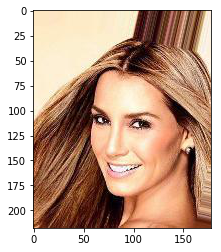

In [273]:
import matplotlib.pyplot as plt

plt.imshow(mpimg)

In [274]:
import cv2

In [275]:
IMG_SIZE = 256

In [276]:
image = cv2.resize(mpimg, (IMG_SIZE, IMG_SIZE), interpolation=cv2.INTER_LANCZOS4)

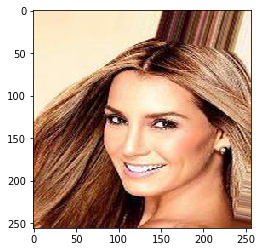

In [277]:
plt.imshow(image)

In [278]:
all_images = []
all_images.append(image)

In [279]:
import numpy as np

In [280]:
data = np.concatenate([img.transpose((2, 0, 1))[None] for img in all_images], 0)
data.shape

(1, 3, 256, 256)

In [281]:
from torch.autograd import Variable

In [282]:
data = data.astype(np.float32)

In [223]:
t_data = torch.from_numpy(data)

### Reconstruct images / create interpolations



In [224]:
from torch.autograd import Variable

In [225]:
t_data = Variable(t_data)

In [226]:
ae = ae.cuda()

In [227]:
t_data = t_data.cuda()

### Forward pass on [auto-encoder](https://github.com/domarps/FaderNetworks/blob/master/src/model.py#L112)

In [306]:
enc_outputs = ae.encode(t_data)

In [308]:
len(enc_outputs)

7

In [229]:
ae.n_attr

2

In [286]:
# interpolation values
alphas = np.linspace(1 - params.alpha_min, params.alpha_max, params.n_interpolations)

In [287]:
alphas

array([-1.        , -0.66666667, -0.33333333,  0.        ,  0.33333333,
        0.66666667,  1.        ,  1.33333333,  1.66666667,  2.        ])

In [288]:
# Use this for multi-attributes 
alphas = [torch.FloatTensor([1 - alpha, alpha, 1 - alpha, alpha]) for alpha in alphas]

In [232]:
#alphas = [torch.FloatTensor([1 - alpha, alpha]) for alpha in alphas]

In [289]:
alphas[0]


 2
-1
 2
-1
[torch.FloatTensor of size 4]

In [290]:
len(alphas)

10

In [291]:
ae.n_attr

4

In [318]:
outputs = []

In [319]:
outputs.append(t_data)

In [320]:
attrs = torch.FloatTensor([1, 0, 1, 0])

In [321]:
attrs = Variable(attrs.unsqueeze(0).expand((1, 4)).cuda())

### Decoder output

In [322]:
outputs.append(ae.decode(enc_outputs, attrs)[-1])

In [323]:
for alpha in alphas:
        alpha = Variable(alpha.unsqueeze(0).expand((1, 4)).cuda())
        outputs.append(ae.decode(enc_outputs, alpha)[-1])

In [324]:
interpolations = torch.cat([x.unsqueeze(1) for x in outputs], 1).data.cpu()

In [325]:
interpolations = torch.cat(interpolations, 0)

In [326]:
from torchvision.utils import make_grid

In [327]:
interpolations.size()

torch.Size([12, 3, 256, 256])

In [328]:
result = interpolations.unsqueeze(0)

result.size()

torch.Size([1, 12, 3, 256, 256])

In [329]:
def get_grid(images, row_wise, plot_size=5):
    """
    Create a grid with all images.
    """
    n_images, n_columns, img_fm, img_sz, _ = images.size()
    if not row_wise:
        images = images.transpose(0, 1).contiguous()
    images = images.view(n_images * n_columns, img_fm, img_sz, img_sz)
    #images.add_(1).div_(2.0)
    return make_grid(images, nrow=(n_columns if row_wise else n_images))

In [330]:
grid = get_grid(result, True, 4)

In [331]:
import matplotlib.image 

In [332]:
matplotlib.image.imsave(params.output_path, grid.numpy().transpose((1, 2, 0)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


In [345]:
from IPython.display import Image
from IPython.core.display import HTML 

### Output for a single image

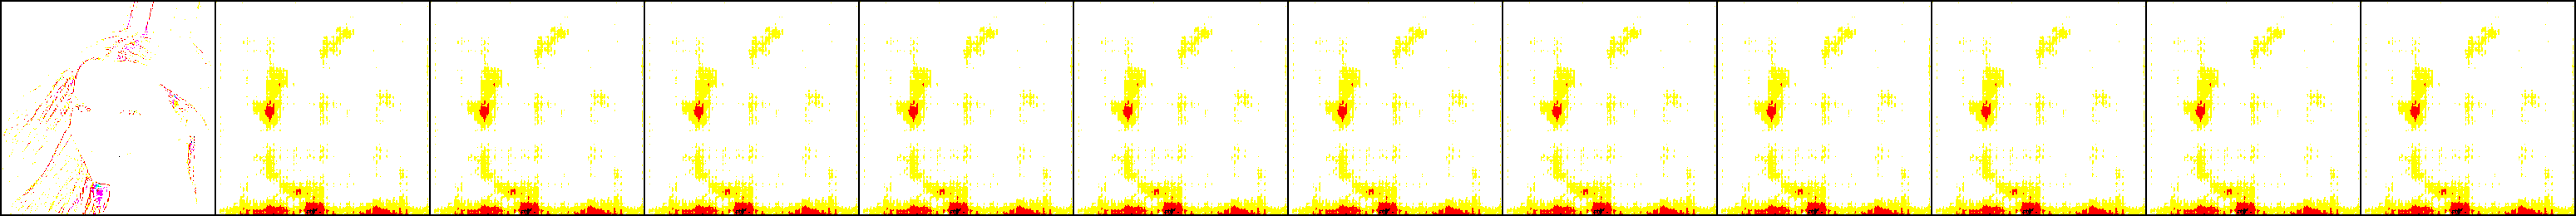

In [349]:
Image(filename = params.output_path, width=10000, height=10000)

In [ ]:
#### Output for multiple images